In [ ]:
#default_exp audio.augment
#default_cls_lvl 3

# Data Augmentation for Audio

> Transforms to apply data augmentation to AudioSpectrograms and Signals

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *

In [ ]:
# export
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
x = AudioGetter("", recurse=True, folders=None)
files = x(p)
aud = AudioItem.create(files[0])

In [ ]:
sg_cfg = SpectrogramConfig(hop = 260)
cfg = AudioConfig(duration=1000, sg_cfg=sg_cfg)

In [ ]:
to_spectrogram = AudioToSpec(cfg)

In [ ]:
original_spec = to_spectrogram(aud)

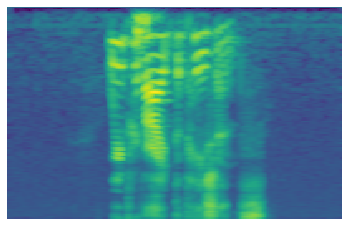

In [ ]:
original_spec.show()

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> 
<ul><li> I'm pretty sure these transforms should extend RandomTransform, not Transform, but I'm not totally sure how to do it yet, so I'll come back</li>
<li> Write tfm_pad_spectro for the case where the crop window is bigger than the original sg and it needs to be padded </li></ul>
</div>

In [ ]:
class CropTime(Transform):
    def __init__(self, cfg):
        self.cfg = cfg
        # width in pixels of the cropping window
        self.w = int((cfg._sr*cfg.duration)/(1000*cfg.sg_cfg.hop))
        
    def encodes(self, spectro:AudioSpectrogram):
        # width in pixels of the spectrogram
        sg = spectro.clone()
        w_sg = sg.shape[-1]
        if   w_sg <  self.w: return self.tfm_pad_spectro(sg)
        elif w_sg == self.w: return sg
        else:
            crop_start = random.randint(0, int(w_sg - self.w))
            sg_crop = sg[:,:,crop_start:crop_start+self.w]
            sg_crop.sample_start = int(crop_start*self.cfg.sg_cfg.hop)
            sg_crop.sample_end   = sg_crop.sample_start + int(cfg.duration*cfg._sr)
            return sg_crop
        
    def tfm_pad_spectro(self, sg):
        pass
    # can we make a decodes that includes the path of the spectrogram in the cache and returns it?
    #def decodes(self, x:AudioSpectrogram):

In [ ]:
cfg.duration = 500

if width of the spectrogram is less than width of the cropping window -> pad
if they are equal -> return unaltered
if width of spectro > width of cropping window, randomly select the cropping window

In [ ]:
cfg._sr = 16000

In [ ]:
crop_500ms = CropTime(cfg)

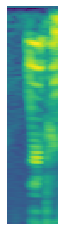

In [ ]:
crop_500ms(original_spec).show()

In [ ]:
a = torch.zeros(5)

In [ ]:
a.unsqueeze(-1).unsqueeze(-1)

tensor([[[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]]])

In [ ]:
a[:,None,None]


tensor([[[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]]])

<div class='alert alert-block alert-warning'>It doesn't look like we need state here, and it causes excess verbosity in that everything has to be called as self.something, refactor back into function</div>

In [ ]:
class MaskSpec(Transform):
    def __init__(self, mask_freq=True, num_masks=1, size=20, start=None, val=None, **kwargs):
        store_attr(self,'mask_freq,num_masks,size,start,val')
        
    def encodes(self, spectro:AudioSpectrogram):
        sg = spectro.clone()
        print(sg.shape)
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = channel_mean if self.val is None else self.val
        c, y, x = sg.shape
        
        #this line is a pretty good indicator I shouldnt be using a Class for this Transform
        num_masks, size, start, val = self.num_masks, self.size, self.start, self.val
        for _ in range(num_masks):
            # there's probably a refactor here to merge these two blocks of code, maybe if mask_freq is false then
            # transpose and run through the same code and then transpose back? 
            if self.mask_freq: 
                mask = torch.ones(size, x) * mask_val
                
                if start is None: start = random.randint(0, y-size)
                if not 0 <= start <= y-size:
                    raise ValueError(f"Column start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}")
                print("mask shape", mask.shape)
                print("start, size", (start, size))
                print("cutout shape", sg[:,start:start+size,:].shape)
                sg[:,start:start+size,:] = mask
            else: 
                mask = torch.ones(y, size) * mask_val
                if start is None: start = random.randint(0, x-size)
                if not 0 <= start <= x-size:
                    raise ValueError(f"Row start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}")
                sg[:,:,start:start+size] = mask
            start = None
        return sg

torch.Size([1, 128, 202])
mask shape torch.Size([1, 20, 202])
start, size (45, 20)
cutout shape torch.Size([1, 20, 202])


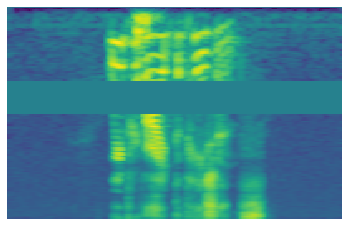

In [ ]:
freq_mask = MaskSpec()
freq_mask(original_spec).show()

In [ ]:
class CropTime(Transform):
    def __init__(self, cfg):
        self.cfg = cfg
        # width in pixels of the cropping window
        self.w = int((cfg._sr*cfg.duration)/(1000*cfg.sg_cfg.hop))
        
    def encodes(self, spectro:AudioSpectrogram):
        # width in pixels of the spectrogram
        sg = spectro.clone()
        w_sg = sg.shape[-1]
        if   w_sg <  self.w: return self.tfm_pad_spectro(sg)
        elif w_sg == self.w: return sg
        else:
            crop_start = random.randint(0, int(w_sg - self.w))
            sg_crop = sg[:,:,crop_start:crop_start+self.w]
            sg_crop.sample_start = int(crop_start*self.cfg.sg_cfg.hop)
            sg_crop.sample_end   = sg_crop.sample_start + int(cfg.duration*cfg._sr)
            return sg_crop
        
    def tfm_pad_spectro(self, sg):
        pass
    # can we make a decodes that includes the path of the spectrogram in the cache and returns it?
    #def decodes(self, x:AudioSpectrogram):

In [ ]:
# export
def _minus_axis(x, axis):
    x[...,axis] = -x[...,axis]
    return x

class PILFlip(RandTransform):
    "Randomly flip with probability `p`"
    def __init__(self, p=0.5): self.p = p
    def encodes(self, x:PILImage):    return x.transpose(Image.FLIP_LEFT_RIGHT)
    def encodes(self, x:TensorPoint): return _minus_axis(x, 0)
    def encodes(self, x:TensorBBox):
        bb,lbl = x
        bb = _minus_axis(bb.view(-1,2), 0)
        return (bb.view(-1,4),lbl)

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_dataloader.ipynb.
Converted 01a_script.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_test_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Converted 36_text_models_qrnn.ipynb.
Converted